# Simple Baseline

In [1]:
import os
import pathlib

if os.path.exists("/kaggle"):
    input_dir = pathlib.Path("/kaggle/input/commonlitreadabilityprize")
    
    !pip install ../input/textstat/Pyphen-0.10.0-py3-none-any.whl
    !pip install ../input/textstat/textstat-0.7.0-py3-none-any.whl
    !pip install ../input/pandarallel151whl/pandarallel-1.5.1-py3-none-any.whl
else:
    input_dir = pathlib.Path("../data/raw")

In [2]:
import os
import re
import time
import pathlib
import textstat
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from pandarallel import pandarallel
from pandas_profiling import ProfileReport

from typing import AnyStr

import rich
from rich import print
from rich.theme import Theme
from rich.console import Console

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords

tqdm.pandas()

pandarallel.initialize(progress_bar=True)

plt.style.use('seaborn-darkgrid')

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
train = pd.read_csv(input_dir / 'train.csv')
test = pd.read_csv(input_dir / 'test.csv')
smpl_sub = pd.read_csv(input_dir / 'sample_submission.csv')

## Preprocessing

In [4]:
def preprocess_excerpt(text: AnyStr):
    text = re.sub("[^a-zA-Z]", " ", text).lower()
    text = nltk.word_tokenize(text)  # NOTE: 英文を単語分割する
    text = [word for word in text if not word in set(stopwords.words("english"))]
    
    lemma = nltk.WordNetLemmatizer()  # NOTE: 複数形の単語を単数形に変換する
    text =  " ".join([lemma.lemmatize(word) for word in text])
    return text

In [5]:
%%time

train['excerpt_preprocessed'] = train['excerpt'].parallel_apply(preprocess_excerpt)
test['excerpt_preprocessed'] = test['excerpt'].parallel_apply(preprocess_excerpt)

CPU times: user 2.27 s, sys: 396 ms, total: 2.67 s
Wall time: 33.4 s


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [7]:
# Ref: https://nigimitama.hatenablog.jp/entry/2020/11/09/080000

class BaseTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self

class TextstatProcessing(BaseTransformer):
    
    def transform(self, X):
        X['excerpt_len'] = X['excerpt_preprocessed'].str.len()
        X['avg_word_len'] = X['excerpt_preprocessed'].apply(lambda x: [len(s) for s in x.split()]).map(np.mean)
        X['char_count'] = X['excerpt'].map(textstat.char_count)
        X['word_count'] = X['excerpt_preprocessed'].map(textstat.lexicon_count)
        X['sentence_count'] = X['excerpt'].map(textstat.sentence_count)
        X['syllable_count'] = X['excerpt'].apply(textstat.syllable_count)
        X['smog_index'] = X['excerpt'].apply(textstat.smog_index)
        X['automated_readability_index'] = X['excerpt'].apply(textstat.automated_readability_index)
        X['coleman_liau_index'] = X['excerpt'].apply(textstat.coleman_liau_index)
        X['linsear_write_formula'] = X['excerpt'].apply(textstat.linsear_write_formula)
        return X
    

class TfidfTransformer(BaseTransformer):
    
    def transform(self, X):
        tfidf_vec = TfidfVectorizer(binary=True, ngram_range=(1,1))
        vector = tfidf_vec.fit_transform(X['excerpt'])
        vector = pd.DataFrame(vector.toarray(), columns=tfidf_vec.get_feature_names())
        pca = PCA(n_components=5)
        pca_vector = pd.DataFrame(pca.fit_transform(vector))
        X = pd.concat([X, pca_vector], axis=1)
        return X
    

class DropFeature(BaseTransformer):
    
    def transform(self, X):
        X.drop(['excerpt', 'excerpt_preprocessed'], axis=1, inplace=True)
        return X

In [8]:
%%time
src_X = train[['excerpt', 'excerpt_preprocessed']].copy()

pipe = Pipeline(steps=[
    ('textstat_processing', TextstatProcessing()),
    ('tfidf', TfidfTransformer()),
    ('drop_feature', DropFeature()),
])

pipe.fit(src_X)

CPU times: user 19.7 s, sys: 2.68 s, total: 22.4 s
Wall time: 13.6 s


Pipeline(steps=[('textstat_processing', TextstatProcessing()),
                ('tfidf', TfidfTransformer()),
                ('drop_feature', DropFeature())])

In [9]:
dst_X = pipe.transform(src_X)
dst_X.head()

,excerpt_len,avg_word_len,char_count,word_count,sentence_count,syllable_count,smog_index,automated_readability_index,coleman_liau_index,linsear_write_formula,0,1,2,3,4
0,591,5.505495,819,91,11,225,8.6,8.3,8.06,9.000000,-0.038045,-0.047436,0.040788,0.048865,-0.021736
1,551,5.494118,774,85,12,222,8.3,7.2,6.78,7.285714,0.097216,0.057800,-0.035791,-0.101759,0.040186
2,527,5.285714,747,84,8,209,10.1,10.1,7.20,14.750000,0.096676,0.014529,-0.018461,-0.035823,0.021789
3,573,5.106383,747,94,5,196,6.7,16.4,8.54,12.500000,0.043273,-0.116141,0.064823,0.048972,0.012214
4,413,4.594595,577,74,5,170,8.8,11.8,4.83,13.500000,0.048841,-0.063656,0.014328,0.117312,-0.012781


## Train Model

In [10]:
from sklearn import model_selection
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor

In [11]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [12]:
def custom_cv(n_splits: int, target: pd.Series, shuffle: bool = True):
    target = target.to_frame()
    num_bins = int(np.floor(1 + np.log2(len(target))))
    target.loc[:, "bins"] = pd.cut(
        target["target"], bins=num_bins, labels=False
    )

    kf = model_selection.StratifiedKFold(n_splits=n_splits)
    for train_idx, test_idx in kf.split(X=target, y=target['bins']):
        yield train_idx, test_idx

In [13]:
X = pipe.transform(src_X)
y = train['target']
cv = custom_cv(5, y)

model = make_pipeline(
    StandardScaler(),
    LinearRegression(normalize=True, n_jobs=-1),
)

result = cross_validate(
    model, 
    X, 
    y, 
    cv=5, 
    scoring={'rmse': make_scorer(rmse)}, 
    return_train_score=True,
    return_estimator=True,
    n_jobs=-1,
)

In [14]:
print(f"fit_time   : {result['fit_time'].mean():.5f}")
print(f"score_time : {result['score_time'].mean():.5f}")
print(f"train_rmse : {result['train_rmse'].mean():.5f}") 
print(f"test_rmse  : {result['test_rmse'].mean():.5f}") 

fit_time   : 0.02289

score_time : 0.00581

train_rmse : 0.72359

test_rmse  : 0.75025

## Prediction

In [15]:
X_test = test[['excerpt', 'excerpt_preprocessed']].copy()
X_test = pipe.transform(X_test)
pred = np.zeros(X_test.shape[0])

for estimator in result['estimator']:
    pred += estimator.predict(X_test) / len(result['estimator'])

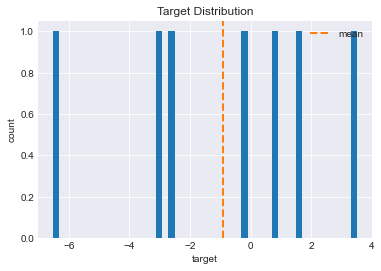

In [16]:
plt.title('Target Distribution')
plt.hist(pred, bins=50)
plt.axvline(pred.mean(), color='tab:orange', linewidth=2, linestyle='--', label='mean')
plt.xlabel('target')
plt.ylabel('count')
plt.legend()